In [1]:
#Set up workspace
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import os
import statsmodels.api as sm
from statsmodels.regression.linear_model import RegressionResults
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import seaborn.apionly as sns
from collections import Counter

#Suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

/Users/thomashill/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Read in Data
neighbors_df_2017 = pd.read_csv("Neighbors_df_2017.csv")
neighbors_df_2017 = neighbors_df_2017.drop(['Unnamed: 0'],axis=1)
neighbors_df_2017 = neighbors_df_2017[neighbors_df_2017['SQFT']!=0] #Important to drop listings with "0" sqft...

/Users/thomashill/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
predictors = ['SOLDPRICE','AGE','BATHS',
              'BEDS','GARAGE','MOS','SQFT']

In [4]:
#Function to split into train and test
def train_test(df,seed=1948,train_portion=0.7):
    np.random.seed(seed)
    msk = np.random.rand(len(df)) < train_portion
    data_train = df[msk]
    data_test = df[~msk]
    
    return data_train,data_test

In [5]:
#Write formula to split into x and y and print out the r^2 using linear regression
def linear_train_and_test(data_train,data_test):
    
    x_train = data_train.drop(['SOLDPRICE'],axis=1)
    y_train = data_train['SOLDPRICE']

    x_test = data_test.drop(['SOLDPRICE'],axis=1)
    y_test = data_test['SOLDPRICE']

    regression = LinearRegression(fit_intercept=False)
    regression.fit(x_train,y_train)

    train_r_sq = regression.score(x_train, y_train)
    test_r_sq = regression.score(x_test, y_test)
        
    return train_r_sq,test_r_sq

In [6]:
#Formula to set up regression model with a variable number of neighbors
def neighbors_regression(df,predictors,num_neighbors=10):
    
    data_train,data_test = train_test(df)
    
    if num_neighbors == 0:
        train_df = data_train[predictors]
        train_df = train_df.replace([np.inf, -np.inf], np.nan)
        train_df = train_df.dropna()
        
        test_df = data_test[predictors]
        test_df = test_df.replace([np.inf, -np.inf], np.nan)
        test_df = test_df.dropna()
        
        train_rsq,test_rsq = linear_train_and_test(train_df,test_df)
        
        return train_rsq,test_rsq
    
    else:
        additional_predictors = list(range(0, num_neighbors))
        additional_predictors_list = [str(i)+'_PPSF' for i in additional_predictors]
        
        train_neibs_df = data_train[additional_predictors_list]
        train_neibs_predicted_prices = train_neibs_df.mean(axis=1)

        test_neibs_df = data_test[additional_predictors_list]
        test_neibs_predicted_prices = test_neibs_df.mean(axis=1)
        
        train_df = data_train[predictors]
        train_df = train_df.assign(Predicted_Prices = train_neibs_predicted_prices)
        train_df = train_df[train_df['Predicted_Prices']<10000000]
        train_df = train_df.replace([np.inf, -np.inf], np.nan)
        train_df = train_df.dropna()
        
        test_df = data_test[predictors]
        test_df = test_df.assign(Predicted_Prices = test_neibs_predicted_prices)
        test_df = test_df[test_df['Predicted_Prices']<10000000]
        test_df = test_df.replace([np.inf, -np.inf], np.nan)
        test_df = test_df.dropna()
        
        train,test = linear_train_and_test(train_df,test_df)
        
        return train,test

In [7]:
neighbors_regression(neighbors_df_2017,predictors,num_neighbors=18)

/Users/thomashill/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:539: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


(0.8377906880631966, 0.8425130935444685)

Let's try making some basic interaction terms - maybe that will improve our R^2?

In [8]:
new_df_2017 = pd.get_dummies(neighbors_df_2017,columns=['TYPE'])

In [9]:
new_df_2017['Condo_beds'] = new_df_2017['TYPE_Condo']*new_df_2017['BEDS']
new_df_2017['SF_beds'] = new_df_2017['TYPE_SF']*new_df_2017['BEDS']
new_df_2017['MF_beds'] = new_df_2017['TYPE_MF']*new_df_2017['BEDS']

In [10]:
new_df_2017['Condo_SQFT'] = new_df_2017['TYPE_Condo']*new_df_2017['SQFT']
new_df_2017['SF_SQFT'] = new_df_2017['TYPE_SF']*new_df_2017['SQFT']
new_df_2017['MF_SQFT'] = new_df_2017['TYPE_MF']*new_df_2017['SQFT']

In [11]:
new_predictors = ['SOLDPRICE','AGE','BATHS',
                  'BEDS','GARAGE','MOS','SQFT',
                  'TYPE_Condo','TYPE_MF','TYPE_SF',
                  'MF_beds','SF_beds','Condo_beds',
                  'Condo_SQFT','SF_SQFT','MF_SQFT']
neighbors_regression(new_df_2017,new_predictors,num_neighbors=18)

(0.8410700679260386, 0.8457998416963388)

Sadly, no. No evident change. 

Does a GAM perform better?

In [12]:
from pygam import LinearGAM

In [13]:
gam_df = new_df_2017[predictors]

new_df_2017 = new_df_2017.replace([np.inf, -np.inf], np.nan)
new_df_2017 = new_df_2017.dropna()

x = gam_df.drop(['SOLDPRICE'],axis=1)
y = gam_df['SOLDPRICE']

In [14]:
#Removed code here because there was an error. Too lazy to fix something that didn't improve our R^2 anyway. 

No....

Note that including City, Type, and ZIP as dummy variable predictors does not substantially change the model's performance on the test set: in fact, it seems to lower it slightly. But perhaps bundling the two regressions together in an ensemble would work: perhaps this would help control for the weaknesses of both models. 

In fact, excluding all other predictors other than the k nearest neighbors barely even lowers the R^2....interesting. Maybe this model should be purely the k-nearest neighbors, and then you ensemble with the other models. 

Similarly, including Months of Supply does not seem to explain anything. But maybe months of supply could help to explain the residuals?

Also, note that predicting on the log of price significantly reduces the R^2, frustratingly. Best to just stick with the raw price. 

In [15]:
num_neighbors = 50

In [16]:
#Build a dataframe with the train and test R^2 for every set of neighbors
train_r_sqs = []
test_r_sqs = []
for i in range(num_neighbors):
    train,test = neighbors_regression(neighbors_df_2017,predictors,i)
    train_r_sqs.append(train)
    test_r_sqs.append(test)

regression_results = pd.DataFrame({
    "Neighbors": list(range(num_neighbors)),
    "Train R^2": train_r_sqs,
    "Test R^2": test_r_sqs})  

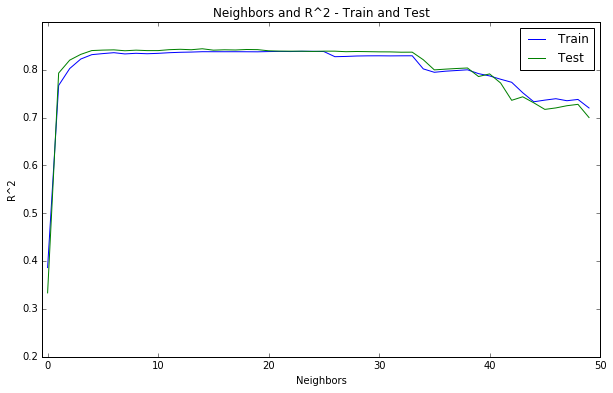

In [17]:
#Plot the Above
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot("Neighbors","Train R^2",data=regression_results,label = 'Train')
ax.plot("Neighbors","Test R^2",data=regression_results,label = 'Test')
ax.set_xlabel('Neighbors')
ax.set_ylabel('R^2')
ax.set_title('Neighbors and R^2 - Train and Test')
ax.set_ylim([0.2,0.9])
ax.set_xlim([-0.5,50])
ax.legend(loc='best')

As the above plot shows, including neighbors significantly increases both the train and test R^2. Including 6 neighbors raises the test R^2 to aproximately 84%, up from 79% with only 1 neighbor or less than 30% with 0 neighbors (and no other locational information such as Zip Code or City). The R^2 rises until about 6 neighbors, at which point it plateaus. 

Beyond 30 neighbors, the R^2 of the model rapidly begins to decline: presumably because the properties included as neighbors for each point in the 2017 data are no longer truly "neighbors" - they are further away, and so have less relevance for predicting the price of the origin property. Since predictions are generated by averaging the [PPSF of each neighbor times the SQFT of the origin property], including increasingly distant neighbors begins to drag down the precision of the predictions.

It's amazing that this model is so accurate with such a small number of predictors, and with no polynomial or interaction terms, or really anything fancy at all. 

Next steps could include: building a hierarchical model, seeing if there still seems to be spatial autocorrelation in the data, and if there is, then possibly finding other ways to include location as a predictor. 

In [18]:
#Find the optimal number of neighbors
opt_neighbors = int(regression_results.loc[regression_results['Test R^2'].idxmax()][0])
opt_train,opt_test = neighbors_regression(neighbors_df_2017,predictors,num_neighbors=opt_neighbors)

print("The optimal number of neighbors is "+ str(opt_neighbors) + ", which yields a test R^2 of "+ str(opt_test))

The optimal number of neighbors is 14, which yields a test R^2 of 0.844035266729022


Now let's see if we can improve on this baseline model. Are there ways to train on the residuals, or engineer other featuers that boost its performance?

In [19]:
#First, let's bundle up all the predicted values based on the optimal number of neighbors into a new dataframe
additional_predictors = list(range(0, opt_neighbors))
additional_predictors_list = [str(i)+'_PPSF' for i in additional_predictors]

df_total = neighbors_df_2017[additional_predictors_list]
predicted_prices = df_total.mean(axis=1)

new_df_2017 = neighbors_df_2017.assign(Predicted_Prices = predicted_prices)
new_df_2017 = new_df_2017[new_df_2017['Predicted_Prices']<10000000]
new_df_2017 = new_df_2017.replace([np.inf, -np.inf], np.nan)

new_predictors = predictors + ['Predicted_Prices'] #+ ['CITY','TYPE','ZIP','STYLE']

new_df_2017 = new_df_2017.dropna(subset=new_predictors)
full_predictors_list = list(new_df_2017.columns)
new_df_2017 = new_df_2017[full_predictors_list]

In [20]:
#Save the above for future use
new_df_2017.to_csv("New_df_2017.csv")

Note: Including all the other predictors, including Zip, City, Type, and Style as Dummies, only marginally improves the R^2 (from 84.4 to 84.5). So maybe it's not worth it to get all these dummies. You'll have to come up with another way to improve the R^2. 

Let's examine our residuals a bit. 

In [21]:
new_df_2017['Residuals'] = (new_df_2017['Predicted_Prices']-new_df_2017['SOLDPRICE'])/new_df_2017['SOLDPRICE']
new_df_2017['Abs_Residuals'] = abs((new_df_2017['Predicted_Prices']-new_df_2017['SOLDPRICE'])/new_df_2017['SOLDPRICE'])


In [22]:
resid_df = new_df_2017[new_df_2017['Residuals']<2]
resid_df = resid_df[resid_df['Residuals']>-2]
resid_df = resid_df[resid_df['DisplayX']>-74]
resid_df = resid_df[resid_df['DisplayY']>41]


(-0.6, 0.6)

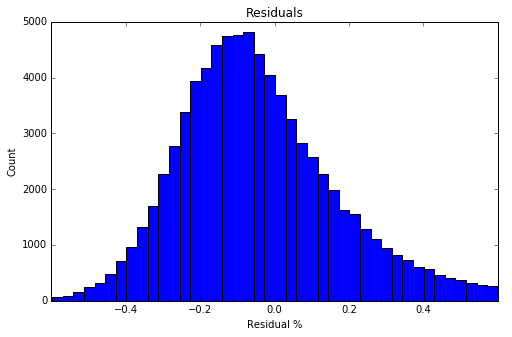

In [23]:
#Residuals Histogram
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.hist(resid_df['Residuals'],bins=100)
ax.set_xlabel('Residual %')
ax.set_ylabel('Count')
ax.set_title('Residuals')
ax.set_xlim([-0.6,0.6])

Hmm, looks like our residuals are not normally distributed around zero - our predictions seem to be slighly lower than 0 on average. What does this mean? 

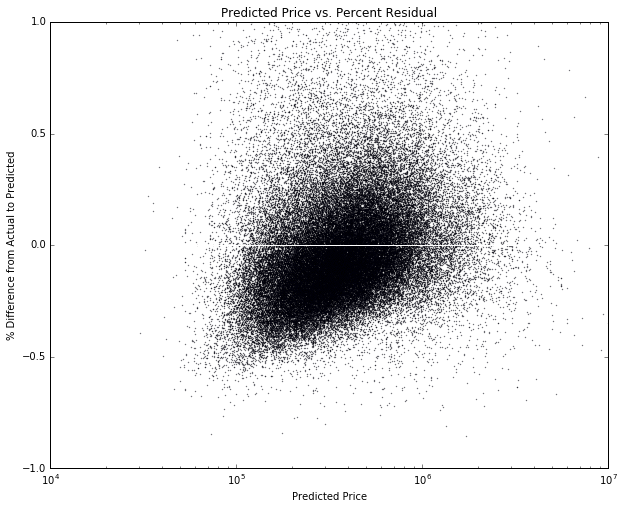

In [24]:
#Residuals plots 

#Sale Price vs. Residuals
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(new_df_2017['Predicted_Prices'],new_df_2017['Residuals'],alpha=0.8,s=.1)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim([10000, 10000000])
ax.set_ylim([-1, 1])
ax.set_xlabel('Predicted Price')
ax.set_ylabel('% Difference from Actual to Predicted')
ax.set_title('Predicted Price vs. Percent Residual')
plt.axhline(0, color='white')


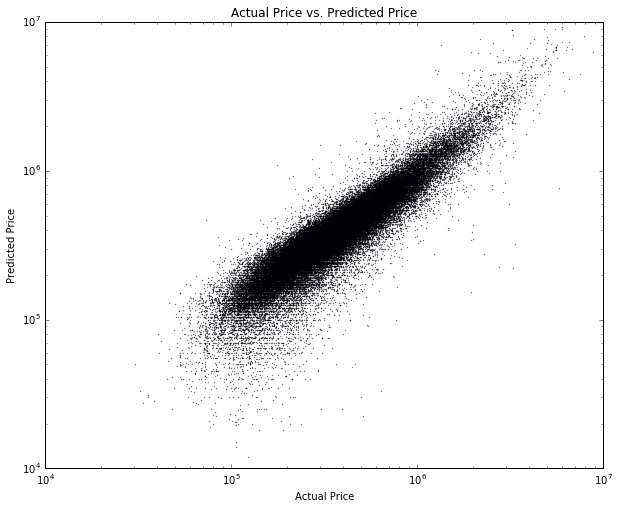

In [25]:
#Residuals plots 

#Sale Price vs. Residuals
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(new_df_2017['Predicted_Prices'],new_df_2017['SOLDPRICE'],alpha=0.8,s=.1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([10000, 10000000])
ax.set_ylim([10000, 10000000])
ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')
ax.set_title('Actual Price vs. Predicted Price')
plt.axhline(0, color='white')


There seems to be a slight correlation between predicted price and the error term...what does this mean we should do? How can we train on these residuals?

Let's see if there still seems to be any spatial auto-correlation. 

Plot some heatmaps next:

In [26]:
def plot_heatmap(df,value='Abs_Residuals',colors='Blues',gridsize=80,title='Residuals Mapped',cb_label='Average Residual %',
                vmin=0,vmax=100):
    long = df['DisplayX'].values
    lat = df['DisplayY'].values
    
    margin = .04 # buffer to add to the range

    y_min = min(lat) - margin
    y_max = max(lat) + margin
    x_min = min(long) - margin
    x_max = max(long) + margin
        
    if value!='Abs_Residuals':
        fig = plt.figure(figsize=(27,20))
        ax = fig.add_subplot(221)
        #ax.hexbin(df['DisplayX'],df['DisplayY'],df[value]*100, vmin=-100, vmax=100,gridsize=gridsize, cmap=colors)
        ax.hexbin(df['DisplayX'],df['DisplayY'],df[value],vmin=vmin,vmax=vmax,gridsize=gridsize, cmap=colors)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(title)
    
        #hb = ax.hexbin(df['DisplayX'],df['DisplayY'],df[value]*100, vmin=-100, vmax=100,gridsize=gridsize, cmap=colors)
        hb = ax.hexbin(df['DisplayX'],df['DisplayY'],df[value], vmin=vmin,vmax=vmax,gridsize=gridsize, cmap=colors)
        cb = fig.colorbar(hb, ax=ax)
        cb.set_label(cb_label)
        #ax.colorbar(hb, ax=ax)
        plt.ylim([y_min, y_max])
        plt.xlim([x_min, x_max])
    else:
        fig = plt.figure(figsize=(27,20))
        ax = fig.add_subplot(221)
        ax.hexbin(df['DisplayX'],df['DisplayY'],df[value]*100, vmin=vmin,vmax=vmax,gridsize=gridsize, cmap=colors)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(title)
    
        hb = ax.hexbin(df['DisplayX'],df['DisplayY'],df[value]*100, vmin=vmin,vmax=vmax,gridsize=gridsize, cmap=colors)
        cb = fig.colorbar(hb, ax=ax)
        cb.set_label(cb_label)
        #ax.colorbar(hb, ax=ax)
        plt.ylim([y_min, y_max])
        plt.xlim([x_min, x_max])       
    
    plt.show()

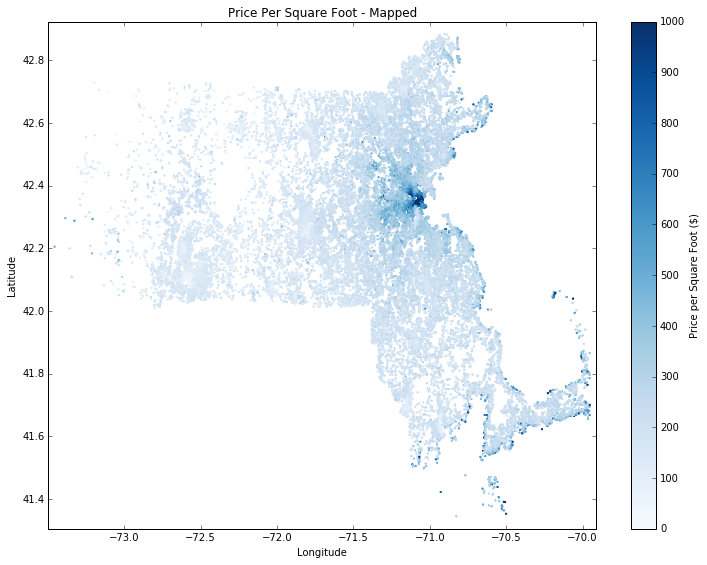

In [49]:
plot_heatmap(resid_df,value='PPSF',gridsize=500,vmin=0,vmax=1000,title="Price Per Square Foot - Mapped",cb_label = 'Price per Square Foot ($)')


The below plot shows the absolute value of the residual %: darker areas have the highest residuals.

We can clearly see that residuals are lowest in the densely settled area around Boston. If we were to subset just Metropolitan Boston, we would no doubt get a higher R^2. 

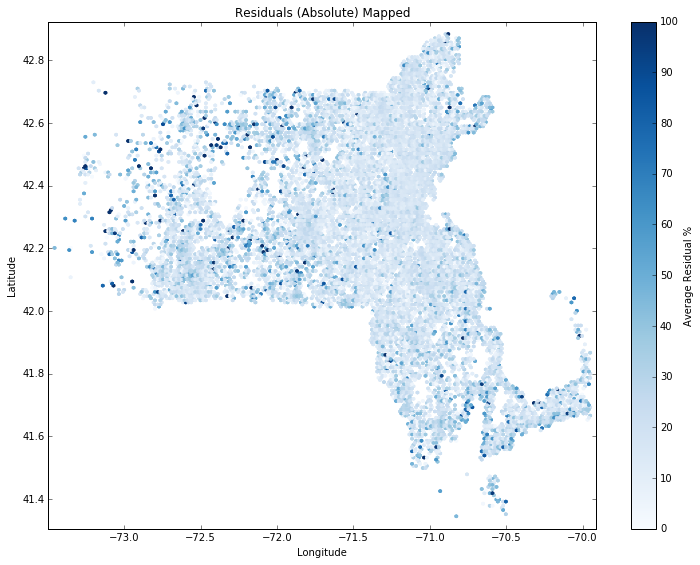

In [51]:
plot_heatmap(resid_df,gridsize=200,title="Residuals (Absolute) Mapped")

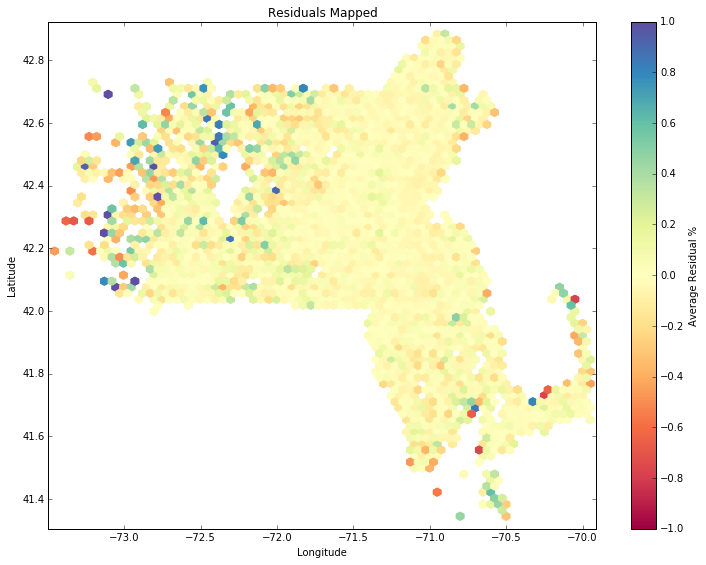

In [29]:
plot_heatmap(resid_df,value='Residuals',colors='Spectral',gridsize=70,vmin=-1,vmax=1)

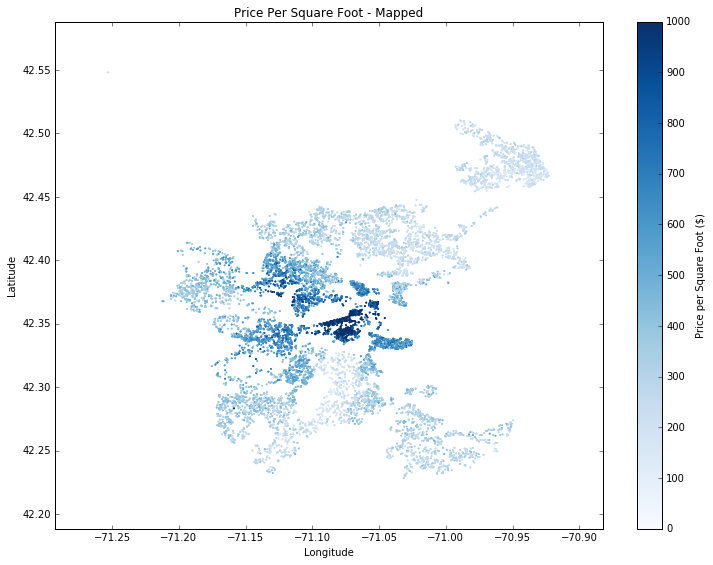

In [30]:
inner_cities = ['Boston', 'Brookline', 'Cambridge','Somerville','Belmont','Watertown','Medford','Chelsea','Quincy',
               'Malden','Everett','Lynn','Revere']
bos_resid_df = resid_df.loc[resid_df['CITY'].isin(inner_cities)]
#bos_resid_df = resid_df[resid_df['CITY']=='Boston']
#plot_heatmap(resid_df,value='PPSF',gridsize=200,title="Price Per Square Foot")
plot_heatmap(bos_resid_df,value='PPSF',gridsize=500,vmin=0,vmax=1000,title="Price Per Square Foot - Mapped",cb_label = 'Price per Square Foot ($)')


In [31]:
opt_neighbor_list = list(range(0, opt_neighbors))
neighbor_dists_list = [str(i)+'_Dist' for i in opt_neighbor_list]

df_total = neighbors_df_2017[neighbor_dists_list]
average_dists = df_total.mean(axis=1)

new_df_2017 = new_df_2017.assign(Average_dists = average_dists)

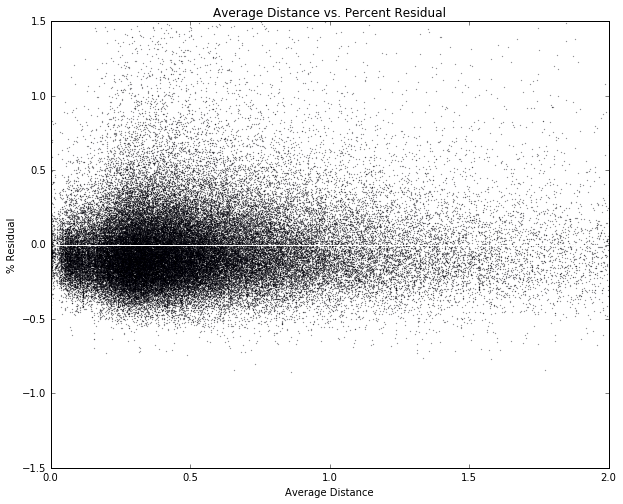

In [32]:
#Average Distance vs. Residuals
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(new_df_2017['Average_dists'],new_df_2017['Residuals'],alpha=0.8,s=.05)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim([0,2])
ax.set_ylim([-1.5,1.5])
ax.set_xlabel('Average Distance')
ax.set_ylabel('% Residual')
ax.set_title('Average Distance vs. Percent Residual')
plt.axhline(0, color='white')


Frustratingly, no evident pattern here either...

In [33]:
new_predictors = predictors + ['Predicted_Prices'] + ['Average_dists']
#other_df_2017 = new_df_2017[new_predictors]

In [34]:
neighbors_regression(new_df_2017,new_predictors,opt_neighbors)

(0.8413802790247057, 0.8355662827578978)

Frustratingly, including average distance does not increase our model's accuracy. 

In [35]:
from collections import Counter
Cities_Dict = dict(Counter(new_df_2017['CITY']))
new_df_2017["City_Size"] = new_df_2017["CITY"].map(Cities_Dict)

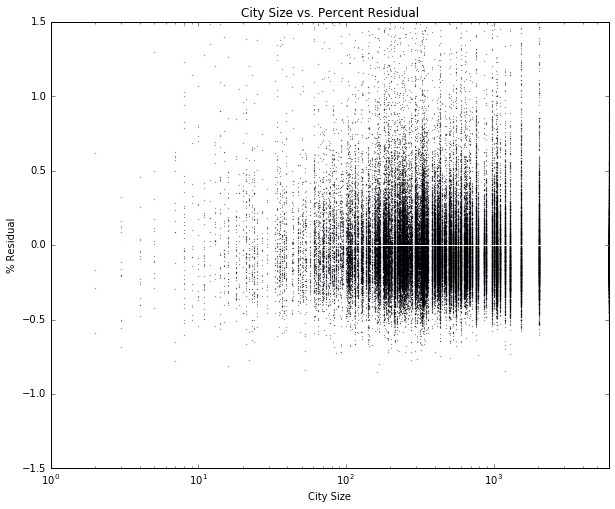

In [36]:
#City Size vs. Residuals
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(new_df_2017['City_Size'],new_df_2017['Residuals'],alpha=0.8,s=.05)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim([0,6000])
ax.set_ylim([-1.5,1.5])
ax.set_xlabel('City Size')
ax.set_ylabel('% Residual')
ax.set_title('City Size vs. Percent Residual')
plt.axhline(0, color='white')


Hmmm...this doesn't seem to help much. Residuals seem to be normally distributed about zero for all city sizes. 

In [37]:
new_df_2017['STYLE']=[str(x) for x in new_df_2017['STYLE']]

style_list = list(new_df_2017['STYLE'])

style_ranges = []
style_types_set = []
for style in style_list:
    style_range = [x.strip() for x in style.split(',')]
    style_ranges.append(style_range)
    for i in style_range:
        style_types_set.append(i)

unique_styles = list(np.unique(style_types_set))

new_df_2017['STYLE']=style_ranges

In [38]:
unique_styles.remove('* Subject to Seller finding suitable housing. Note - Agent has to accompany showings - dog on the premises.')

In [39]:
unique_styles.remove('Entrance on grade level.    First floor: Gourmet kitchen sub zero refrigerator and Miele steam oven')

In [40]:
unique_styles.remove('a 2 car garage')
unique_styles.remove('a great yard with a back patio')
unique_styles.remove('and a half bath.  Conveniently located to all major routes.')
unique_styles.remove('and an attached 1 car garage. In addition')
unique_styles.remove('and built-in coffee system. Dining room')
unique_styles.remove('and the first floor full bath completely redone in 2016. The roof is only 10 years old and has new ice dam protection. The spacious')
unique_styles.remove('dry basement with high ceilings is perfect for a workshop. The large back deck overlooks tranquil shade gardens. Come see this unique property today!')
unique_styles.remove('full bath and laundry')
unique_styles.remove('laundry hook-up')
unique_styles.remove('library and 1/2 bath.  Front and side entrance at grade level.    Second floor: master bedroom with walk in closet')
unique_styles.remove('living room')
unique_styles.remove('master chef oven')
unique_styles.remove('new front porch and a new roof. Nice yard with garden space.')
unique_styles.remove('potting shed')
unique_styles.remove('style house has vinyl siding')
unique_styles.remove('the full basement has a workshop')
unique_styles.remove('the highest point in Needham.  Located')
unique_styles.remove('throughout and features an in law apartment on the second floor. It is located in a quiet neighborhood with access to all major routes. The kitchen was remodeled in 2011')
unique_styles.remove('two additional bedrooms and full bath.      Meticulously restored and maintained home situated on Bird’s Hill')




In [41]:
style_counts_set = []
for unique_style in unique_styles:
    style_counts = []
    for i in new_df_2017['STYLE']:
        style_count = i.count(unique_style)
        style_counts.append(style_count)
    style_counts_set.append(style_counts)
#style_counts = style_counts.transpose()
#style_counts = pd.DataFrame(style_counts,columns=unique_styles)
style_df = pd.DataFrame(style_counts_set)
style_df = style_df.transpose()
style_df.columns = unique_styles

In [42]:
new_df_2017_styles = pd.concat([new_df_2017,style_df],axis=1)

In [43]:
newer_predictors = new_predictors + unique_styles

In [44]:
neighbors_regression(new_df_2017_styles,newer_predictors,opt_neighbors)

(0.8353653823684074, 0.8551790754490605)

Frustratingly, including styles does not increase the R^2 appreciably. So let's go back to using our old dataset with no styles.